In [1]:
%matplotlib inline

In [190]:
import os
import json

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

from utils.exploratory import zip_dtype

In [3]:
plt.rcParams['figure.figsize'] = [20,20]

In [4]:
root_folder = os.path.relpath('../')
data_base = os.path.relpath('../data')
escolas = os.path.join(data_base, 'escolas')
docencias = os.path.join(data_base, 'docencias')
ideb = os.path.join(data_base, 'ideb')
municipios = os.path.join(data_base, 'municipios')
redes = os.path.join(data_base, 'redes')
schemas = os.path.join(root_folder, 'schemas/')

In [5]:
escolas_schema = zip_dtype(os.path.join(schemas, 'escolas_schema.json'))
municipios_schema = zip_dtype(os.path.join(schemas, 'municipios_schema.json'))
redes_schema = zip_dtype(os.path.join(schemas, 'redes_schema.json'))
ideb_schema = zip_dtype(os.path.join(schemas, 'ideb_schema.json'))
docencias_schema = zip_dtype(os.path.join(schemas, 'docencias_schema.json'))

In [6]:
def is_constant(x):
    try:
        x = x.values
    except AttributeError:
        pass

    return ((x == x[0]).all() or pd.Series(x).isnull().all())

In [7]:
def filter_ideb(ideb):
    cols_type_str = ['Co_UF', 'Nome_Municipio', 'Nome_Escola', 'Rede']
    df = ideb.copy()
    for col in df:
        if col in cols_type_str:
            df[col] = ideb[col].astype('str')
        else:
            df[col] = ideb[col].astype(str).str.replace(',', '.').str.replace('*', '').str.replace('ND','NaN').astype(np.float64)
    return df

In [8]:
def merge_ideb_to_frame(year, frame, ideb_iniciais, ideb_finais):
    cols = ideb_iniciais.columns[ideb_iniciais.columns.str.contains(r'Cod_Escola_Completo|'+'Ideb'+str(year))]
    ideb_iniciais_ano = ideb_iniciais[cols]
    cols = ideb_finais.columns[ideb_finais.columns.str.contains(r'Cod_Escola_Completo|'+'Ideb'+str(year))]
    ideb_finais_ano = ideb_finais[cols]

    frame_merge = frame.merge(ideb_iniciais_ano, left_on='cod_escola_inep', right_on='Cod_Escola_Completo', how='left', suffixes=['',''])
    frame_merge = frame_merge.merge(ideb_finais_ano, left_on='cod_escola_inep', right_on='Cod_Escola_Completo', how='left', suffixes=['','_final'])

    return frame_merge

def load_escolas(year):
    escolas = pd.read_csv('../data/escolas/escolas' + str(year) + '0101.csv',
                               dtype=zip_dtype('../schemas/escolas_schema.json'))
    escolas['cod_escola_inep'] = escolas['cod_escola_inep'].astype('int')
    constant_columns = escolas.apply(lambda x: is_constant(x))
    escolas = escolas.drop(constant_columns[constant_columns==True].index, axis=1)
    escolas = escolas[escolas['tp_rede'].str.lower() != 'privada']
    escolas = escolas[escolas['tp_rede_publica'] == True]
    
    return escolas

def clean_escola(escolas):
    to_remove = []
    to_int = []    
    for col in escolas.columns:
        col_type = escolas[col].dtype

        if col_type == 'object':
            to_remove.append(col)
        elif col_type == 'bool':
            to_int.append(col)

    escolas = escolas.drop(to_remove,axis=1)
    escolas[to_int] = escolas[to_int].astype(int)
    
    return escolas

In [9]:
def tabela_ideb_merge(year, tabela, ideb_iniciais, ideb_finais):
    cols = ideb_iniciais.columns[ideb_iniciais.columns.str.contains(r'Cod_Escola_Completo|'+str(year))]
    ideb_iniciais_ano = ideb_iniciais[cols]
    cols = ideb_finais.columns[ideb_finais.columns.str.contains(r'Cod_Escola_Completo|'+str(year))]
    ideb_finais_ano = ideb_finais[cols]
    
    tabela['cod_escola_inep'] = tabela['cod_escola_inep'].astype(np.float64)
    
    tabela_merge = tabela.merge(ideb_iniciais_ano, left_on='cod_escola_inep', right_on='Cod_Escola_Completo', how='left', suffixes=['',''])
    tabela_merge = tabela_merge.merge(ideb_finais_ano, left_on='cod_escola_inep', right_on='Cod_Escola_Completo', how='left', suffixes=['','_final'])
    
    return tabela_merge

## Calculando novas variáveis

In [10]:
escolas_2007 = load_escolas(2007)
escolas = escolas_2007

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (10,12,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,124,125,126,127,128,129,130,136,155,191) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [11]:
escolas.head()

Unnamed: 0  cod_escola_inep regiao unidade_federativa       mesoregiao  \
0           0         11000910  Norte           Rondônia  Madeira-Guaporé   
1           1         12001139  Norte               Acre    Vale do Juruá   
2           2         12020192  Norte               Acre     Vale do Acre   
3           3         12009164  Norte               Acre     Vale do Acre   
4           4         12001015  Norte               Acre    Vale do Juruá   

       microregiao        municipio tp_dependencia tp_dependencia_desc  \
0      Porto Velho      Porto Velho              2            Estadual   
1  Cruzeiro do Sul  Cruzeiro do Sul              2            Estadual   
2       Rio Branco       Rio Branco              2            Estadual   
3       Rio Branco       Acrelândia              2            Estadual   
4  Cruzeiro do Sul  Cruzeiro do Sul              2            Estadual   

  tp_rede_publica     ...      ideb_2015_af_media_mat  \
0            True     ...                      285.37   
1            True     ...                      218.92   
2            True     ...                      253.34   
3            True     ...                         NaN   
4            True     ...                      254.21   

  ideb_2015_af_proficiencia ideb_2015_af_fluxo ideb_2015_anos_finais  \
0                      6.10               0.86                   5.2   
1                      4.24               0.87                   3.7   
2                      5.29               0.97                   5.1   
3                       NaN               0.97                   NaN   
4                      5.23               0.99                   5.2   

  tp_localizacao_diferenciada tp_localizacao_diferenciada_desc  \
0                           0                    Não se aplica   
1                           0                    Não se aplica   
2                           0                    Não se aplica   
3                           0                    Não se aplica   
4                           0                    Não se aplica   

   in_educacao_indigena  co_lingua_indigena  cod_municipio  cod_ibge_uf  
0                 False                 NaN        1100205           11  
1                 False                 NaN        1200203           12  
2                 False                 NaN        1200401           12  
3                 False                 NaN        1200013           12  
4                 False                 NaN        1200203           12  

[5 rows x 134 columns]

Alunos por professores

In [12]:
# escolas['alunos_por_prof'] = escolas.num_estudantes / escolas.num_professores
escolas['alunos_por_prof_fund_ai'] = escolas.num_estudantes_ensino_fund_anos_iniciais / escolas.num_professores_em_regencia_fund_ai
escolas['alunos_por_prof_fund_af'] = escolas.num_estudantes_ensino_fund_anos_finais / escolas.num_professores_em_regencia_fund_af
escolas['alunos_por_prof_medio'] = (escolas[[col for col in escolas.columns if 'num_estudantes_medio' in col]].sum(axis=1) 
                                    / escolas.num_professores_em_regencia_ens_medio)
escolas['alunos_por_turma'] = escolas['num_estudantes'] / escolas['num_turmas']

escolas['turmas_por_professor'] = escolas['num_turmas'] / escolas['num_professores']
escolas['percentual_professores_em_regencia'] = escolas['num_professores_em_regencia'] / escolas['num_professores']

escolas['funcionarios_por_aluno'] = escolas['num_funcionarios'] / escolas['num_estudantes']
escolas['funcionarios_por_professor'] = escolas['num_funcionarios'] / escolas['num_professores']

escolas['num_alunos_por_sala_existente'] = escolas['num_estudantes'] / escolas['num_salas_existentes']
escolas['num_alunos_por_sala_utilizada'] = escolas['num_estudantes'] / escolas['num_salas_utilizadas']

#### Número de alunos que evadiu ou se absteve da prova

In [13]:
# Verificando se pode haver relação entre num_matriculas e evasão
(escolas['num_matriculas'] > escolas['num_estudantes']).sum()

21383

In [14]:
escolas['evasao_abstencao_alunos'] = escolas['num_matriculas'] - escolas['num_estudantes']
escolas['percentual_evasao_abstencao_alunos'] = (escolas['num_matriculas'] - escolas['num_estudantes']) / escolas['num_matriculas']

In [15]:
docencias_2007 = pd.read_csv(os.path.join(docencias, 'docencias20170101000000000000.csv'), encoding='utf-8', dtype=docencias_schema)
docencias_2007['cod_escola_inep'] = docencias_2007['cod_escola_inep'].astype('int')

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
escolas_docencias_2007 = escolas.merge(docencias_2007, on='cod_escola_inep')

In [17]:
escolas_docencias_2007.head()

Unnamed: 0  cod_escola_inep regiao_x unidade_federativa_x       mesoregiao  \
0           0         11000910    Norte             Rondônia  Madeira-Guaporé   
1           0         11000910    Norte             Rondônia  Madeira-Guaporé   
2           0         11000910    Norte             Rondônia  Madeira-Guaporé   
3           0         11000910    Norte             Rondônia  Madeira-Guaporé   
4           0         11000910    Norte             Rondônia  Madeira-Guaporé   

   microregiao  municipio_x tp_dependencia tp_dependencia_desc_x  \
0  Porto Velho  Porto Velho              2              Estadual   
1  Porto Velho  Porto Velho              2              Estadual   
2  Porto Velho  Porto Velho              2              Estadual   
3  Porto Velho  Porto Velho              2              Estadual   
4  Porto Velho  Porto Velho              2              Estadual   

  tp_rede_publica_x               ...               form_adequada_ciencias  \
0              True               ...                                False   
1              True               ...                                False   
2              True               ...                                False   
3              True               ...                                False   
4              True               ...                                False   

  form_adequada_quimica form_adequada_fisica form_adequada_biologia  \
0                 False                False                  False   
1                 False                False                  False   
2                 False                False                  False   
3                 False                False                  False   
4                 False                False                  False   

  form_adequada_estudos_sociais form_adequada_historia  \
0                         False                  False   
1                         False                  False   
2                         False                  False   
3                         False                  False   
4                         False                  False   

   form_adequada_geografia  form_adequada_sociologia  form_adequada_filosofia  \
0                    False                     False                    False   
1                    False                     False                    False   
2                    False                     False                    False   
3                    False                     False                    False   
4                    False                     False                    False   

   form_adequada_ensino_religioso  
0                           False  
1                           False  
2                           False  
3                           False  
4                           False  

[5 rows x 219 columns]

In [18]:
escolas_docencias_2007 = escolas_docencias_2007.merge(docencias_2007.groupby('cod_escola_inep', as_index=False)['num_disciplinas_ensina'].sum(), on='cod_escola_inep')

In [19]:
escolas_docencias_2007.head()

Unnamed: 0  cod_escola_inep regiao_x unidade_federativa_x       mesoregiao  \
0           0         11000910    Norte             Rondônia  Madeira-Guaporé   
1           0         11000910    Norte             Rondônia  Madeira-Guaporé   
2           0         11000910    Norte             Rondônia  Madeira-Guaporé   
3           0         11000910    Norte             Rondônia  Madeira-Guaporé   
4           0         11000910    Norte             Rondônia  Madeira-Guaporé   

   microregiao  municipio_x tp_dependencia tp_dependencia_desc_x  \
0  Porto Velho  Porto Velho              2              Estadual   
1  Porto Velho  Porto Velho              2              Estadual   
2  Porto Velho  Porto Velho              2              Estadual   
3  Porto Velho  Porto Velho              2              Estadual   
4  Porto Velho  Porto Velho              2              Estadual   

  tp_rede_publica_x            ...            form_adequada_quimica  \
0              True            ...                            False   
1              True            ...                            False   
2              True            ...                            False   
3              True            ...                            False   
4              True            ...                            False   

  form_adequada_fisica form_adequada_biologia form_adequada_estudos_sociais  \
0                False                  False                         False   
1                False                  False                         False   
2                False                  False                         False   
3                False                  False                         False   
4                False                  False                         False   

  form_adequada_historia form_adequada_geografia  form_adequada_sociologia  \
0                  False                   False                     False   
1                  False                   False                     False   
2                  False                   False                     False   
3                  False                   False                     False   
4                  False                   False                     False   

   form_adequada_filosofia  form_adequada_ensino_religioso  \
0                    False                           False   
1                    False                           False   
2                    False                           False   
3                    False                           False   
4                    False                           False   

   num_disciplinas_ensina_y  
0                      48.0  
1                      48.0  
2                      48.0  
3                      48.0  
4                      48.0  

[5 rows x 220 columns]

In [20]:
# num_disciplinas_ensina: média do número de disciplinas dadas por professor por escola 
escolas_docencias_2007 = escolas_docencias_2007.merge(docencias_2007.groupby('cod_escola_inep', as_index=False)['num_disciplinas_ensina'].mean(), on='cod_escola_inep')

# quantidade de professores que possuem ensino superior por escola
escolas_docencias_2007 = escolas_docencias_2007.merge(docencias_2007.groupby('cod_escola_inep', as_index=False)['tem_ensino_superior'].sum(), on='cod_escola_inep')

In [21]:
#escolas_docencias_2007 = escolas_docencias_2007.merge(escolas_2007[['infra_lab','cod_escola_inep']], on='cod_escola_inep')

In [22]:
escolas_docencias_2007.head()

Unnamed: 0  cod_escola_inep regiao_x unidade_federativa_x       mesoregiao  \
0           0         11000910    Norte             Rondônia  Madeira-Guaporé   
1           0         11000910    Norte             Rondônia  Madeira-Guaporé   
2           0         11000910    Norte             Rondônia  Madeira-Guaporé   
3           0         11000910    Norte             Rondônia  Madeira-Guaporé   
4           0         11000910    Norte             Rondônia  Madeira-Guaporé   

   microregiao  municipio_x tp_dependencia tp_dependencia_desc_x  \
0  Porto Velho  Porto Velho              2              Estadual   
1  Porto Velho  Porto Velho              2              Estadual   
2  Porto Velho  Porto Velho              2              Estadual   
3  Porto Velho  Porto Velho              2              Estadual   
4  Porto Velho  Porto Velho              2              Estadual   

  tp_rede_publica_x          ...           form_adequada_biologia  \
0              True          ...                            False   
1              True          ...                            False   
2              True          ...                            False   
3              True          ...                            False   
4              True          ...                            False   

  form_adequada_estudos_sociais form_adequada_historia  \
0                         False                  False   
1                         False                  False   
2                         False                  False   
3                         False                  False   
4                         False                  False   

  form_adequada_geografia form_adequada_sociologia form_adequada_filosofia  \
0                   False                    False                   False   
1                   False                    False                   False   
2                   False                    False                   False   
3                   False                    False                   False   
4                   False                    False                   False   

   form_adequada_ensino_religioso  num_disciplinas_ensina_y  \
0                           False                      48.0   
1                           False                      48.0   
2                           False                      48.0   
3                           False                      48.0   
4                           False                      48.0   

   num_disciplinas_ensina  tem_ensino_superior_y  
0                1.297297                     37  
1                1.297297                     37  
2                1.297297                     37  
3                1.297297                     37  
4                1.297297                     37  

[5 rows x 222 columns]

In [23]:
constant_columns = escolas_docencias_2007.apply(lambda x: is_constant(x))
esc_drop = escolas_docencias_2007.drop(constant_columns[constant_columns==True].index,axis=1)

In [24]:
escolas_docencias_2007.head()

Unnamed: 0  cod_escola_inep regiao_x unidade_federativa_x       mesoregiao  \
0           0         11000910    Norte             Rondônia  Madeira-Guaporé   
1           0         11000910    Norte             Rondônia  Madeira-Guaporé   
2           0         11000910    Norte             Rondônia  Madeira-Guaporé   
3           0         11000910    Norte             Rondônia  Madeira-Guaporé   
4           0         11000910    Norte             Rondônia  Madeira-Guaporé   

   microregiao  municipio_x tp_dependencia tp_dependencia_desc_x  \
0  Porto Velho  Porto Velho              2              Estadual   
1  Porto Velho  Porto Velho              2              Estadual   
2  Porto Velho  Porto Velho              2              Estadual   
3  Porto Velho  Porto Velho              2              Estadual   
4  Porto Velho  Porto Velho              2              Estadual   

  tp_rede_publica_x          ...           form_adequada_biologia  \
0              True          ...                            False   
1              True          ...                            False   
2              True          ...                            False   
3              True          ...                            False   
4              True          ...                            False   

  form_adequada_estudos_sociais form_adequada_historia  \
0                         False                  False   
1                         False                  False   
2                         False                  False   
3                         False                  False   
4                         False                  False   

  form_adequada_geografia form_adequada_sociologia form_adequada_filosofia  \
0                   False                    False                   False   
1                   False                    False                   False   
2                   False                    False                   False   
3                   False                    False                   False   
4                   False                    False                   False   

   form_adequada_ensino_religioso  num_disciplinas_ensina_y  \
0                           False                      48.0   
1                           False                      48.0   
2                           False                      48.0   
3                           False                      48.0   
4                           False                      48.0   

   num_disciplinas_ensina  tem_ensino_superior_y  
0                1.297297                     37  
1                1.297297                     37  
2                1.297297                     37  
3                1.297297                     37  
4                1.297297                     37  

[5 rows x 222 columns]

In [25]:
ideb_iniciais = pd.read_csv('../data/ideb/ideb_escolas_anosiniciais2005_2017.csv', encoding='latin1', na_values=['-', 'ND','ND**'])
ideb_iniciais = filter_ideb(ideb_iniciais)
ideb_iniciais['Cod_Municipio_Completo'] = ideb_iniciais['Cod_Municipio_Completo'].astype(np.float64)

ideb_finais = pd.read_csv('../data/ideb/ideb_escolas_anosfinais2005_2017.csv', encoding='latin1', na_values=['-', 'ND','ND**'])
ideb_finais = filter_ideb(ideb_finais)
ideb_finais['Cod_Municipio_Completo'] = ideb_finais['Cod_Municipio_Completo'].astype(np.float64)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (64,65,67,68,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (60,61,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
ideb_escolas = tabela_ideb_merge(2017, esc_drop, ideb_iniciais, ideb_finais)

In [27]:
corr = ideb_escolas.corr()
corr = corr.fillna(0.0)
sns.clustermap(corr, vmin=-1, vmax=1,
               xticklabels=corr.columns.values,
               yticklabels=corr.columns.values,
               cmap="RdBu_r")

/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [28]:
select_columns_raw = [column for column in ideb_escolas.columns if not (
    column.startswith('ideb_')
    or column.startswith('Taxa')
    or column.startswith('num_estudantes')
    or column.startswith('num_matriculas')
    or column.startswith('num_funcionarios')
    or column.startswith('num_professores')
    or column.startswith('num_salas')
    or column.startswith('Nota')
    or column.startswith('Projecao')
    or column.startswith('etapa')
    or column.startswith('Indicador')
    or column.startswith('Unnamed')
    or column.endswith('_x')
    or column.endswith('_y')
    or column.endswith('_desc')
)]

drop_columns = [
                'tp_ocupacao_galpao',
                'tp_ocupacao_predio_escolar',
                'in_dependencias_outras',
                'num_turmas'
               ]

In [29]:
(set(select_columns_raw) - set(drop_columns))

{'Cod_Escola_Completo',
 'Cod_Escola_Completo_final',
 'Ideb2017',
 'Ideb2017_final',
 'alunos_por_prof_fund_af',
 'alunos_por_prof_fund_ai',
 'alunos_por_prof_medio',
 'alunos_por_turma',
 'co_lingua_indigena',
 'co_pessoa_fisica',
 'cod_escola_inep',
 'cod_ibge_uf',
 'docente_em_regencia',
 'ensina_disc_artes',
 'ensina_disc_biologia',
 'ensina_disc_ciencias',
 'ensina_disc_educacao_fisica',
 'ensina_disc_ensino_religioso',
 'ensina_disc_estudos_sociais',
 'ensina_disc_filosofia',
 'ensina_disc_fisica',
 'ensina_disc_geografia',
 'ensina_disc_historia',
 'ensina_disc_lingua_estrangeira',
 'ensina_disc_lingua_portuguesa',
 'ensina_disc_matematica',
 'ensina_disc_quimica',
 'ensina_disc_sociologia',
 'evasao_abstencao_alunos',
 'form_adequada_artes',
 'form_adequada_biologia',
 'form_adequada_ciencias',
 'form_adequada_educacao_fisica',
 'form_adequada_ensino_religioso',
 'form_adequada_estudos_sociais',
 'form_adequada_filosofia',
 'form_adequada_fisica',
 'form_adequada_geografia',
 

In [62]:
esc_ideb_clean = ideb_escolas[select_columns_raw]
esc_ideb_clean = esc_ideb_clean.drop(drop_columns, axis=1)
esc_ideb_clean = esc_ideb_clean.dropna(subset=['Ideb2017','Ideb2017_final'])
# Desconsiderando escolas em que há alunos para uma etapa, mas não há professores
esc_ideb_clean = esc_ideb_clean.replace(np.inf, np.NaN)
esc_ideb_clean = esc_ideb_clean.dropna(subset=['alunos_por_prof_fund_ai',
                                               'alunos_por_prof_fund_af',
                                               'alunos_por_prof_medio'])

In [32]:
y = esc_ideb_clean.reset_index()['Ideb2017']
y_final = esc_ideb_clean.reset_index()['Ideb2017_final']
esc_ideb_clean = esc_ideb_clean.drop(['Ideb2017','Ideb2017_final'], axis=1)
esc_ideb_clean = esc_ideb_clean.drop(['cod_escola_inep', 'Cod_Escola_Completo', 'Cod_Escola_Completo_final'], axis=1)

In [116]:
esc_ideb_clean = clean_escola(esc_ideb_clean)
esc_ideb_clean = esc_ideb_clean.fillna(esc_ideb_clean.mean())

In [34]:
constant_columns = esc_ideb_clean.apply(lambda x: is_constant(x))
esc_ideb_clean = esc_ideb_clean.drop(constant_columns[constant_columns==True].index,axis=1)

In [35]:
# to_normalize = [x[0] for x in (esc_ideb_clean.dtypes == 'float64').items() if x[1]]
scalers = {k: preprocessing.RobustScaler().fit(esc_ideb_clean[k].values.reshape(-1, 1)) for k in esc_ideb_clean.columns}
for column in esc_ideb_clean.columns:
    esc_ideb_clean[column] = scalers[column].transform(esc_ideb_clean[column].values.reshape(-1, 1))

In [36]:
reg = LinearRegression().fit(esc_ideb_clean, y)

In [37]:
pred_ideb = reg.predict(esc_ideb_clean)

In [38]:
plt.plot(y)
plt.plot(pred_ideb)

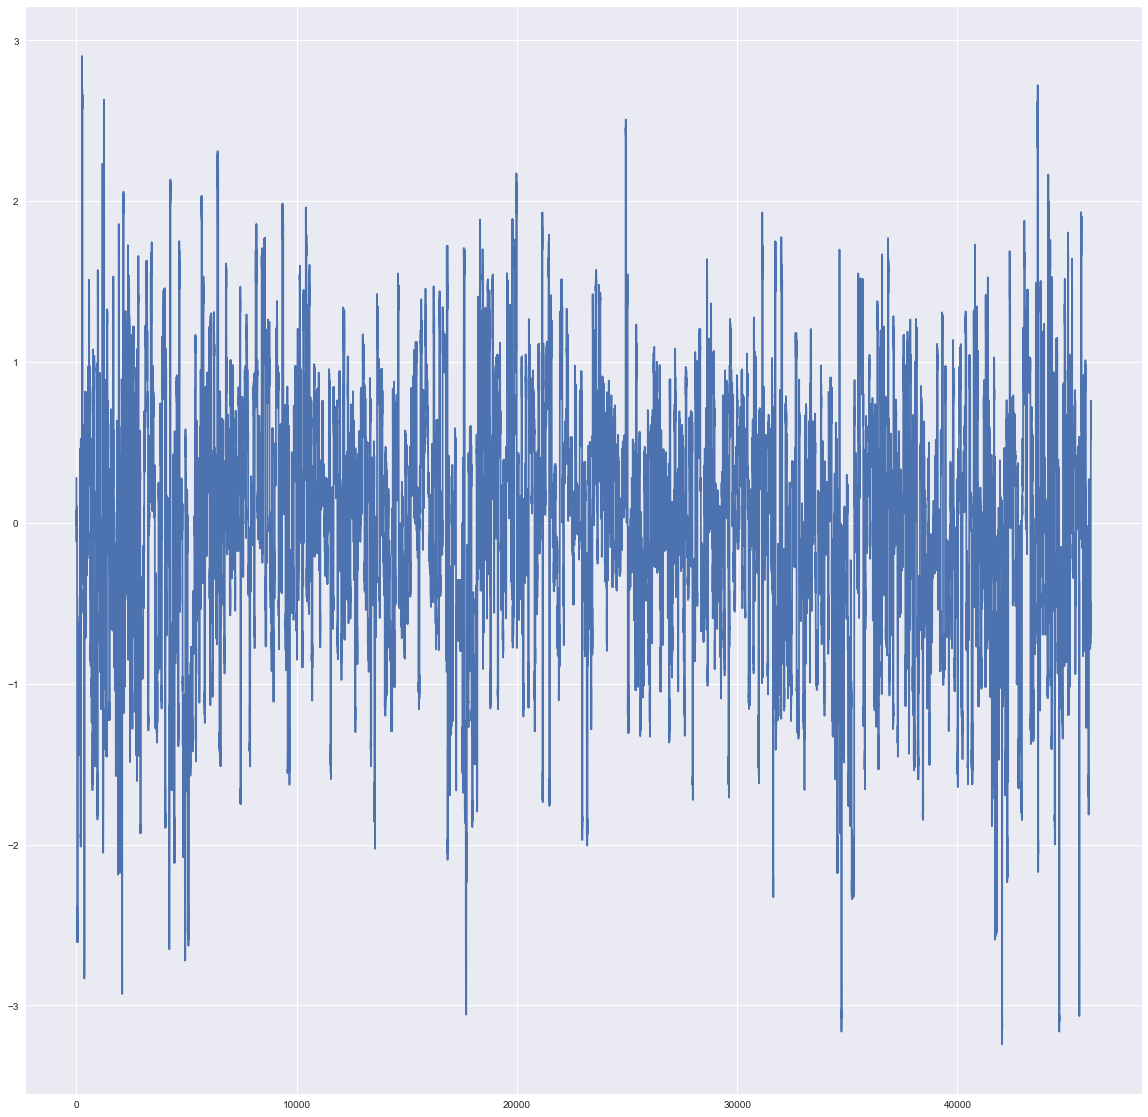

In [39]:
plt.plot(y - pred_ideb)

In [40]:
reg.coef_

array([  5.01605570e-01,  -5.52830704e-01,  -2.85049188e-01,
        -8.66621889e-02,  -4.70196357e-03,  -2.98107533e-01,
         5.64012225e-02,   6.93150686e-02,   1.40660054e-01,
         2.93365857e-01,  -4.49961462e-02,   3.59452974e-01,
        -1.61291424e-01,  -6.82689518e-01,  -9.88977420e-01,
        -1.09383631e+00,   2.90859519e-01,   6.53337900e-02,
        -5.71660877e-01,   4.04571782e-01,  -1.56182463e-03,
        -9.55398881e-02,   9.47677911e-02,  -2.22945662e-01,
         1.97422988e-01,  -5.59463256e-02,   7.47652187e-02,
        -7.30805447e-02,   1.69914736e-01,  -2.83887878e-02,
         1.44231667e-01,  -2.70608367e-01,   1.15012612e-01,
         1.34589357e-01,   1.67889611e-02,   3.56184062e-01,
         3.76281933e-02,  -6.57746763e-02,   8.56743011e-02,
         1.87862215e-01,   3.58503782e-02,   5.71460918e-02,
         6.88641534e-02,   2.37564073e-01,   3.28722178e-01,
        -1.73644116e-01,   2.51057118e-02,  -8.32438954e-01,
        -4.72170289e-02,

In [41]:
[(y, x) for x, y in sorted(zip(reg.coef_, esc_ideb_clean.columns))]

[('in_energia_outros', -1.0938363120037224),
 ('in_energia_gerador', -0.98897742023515833),
 ('in_educacao_indigena', -0.83243895427083858),
 ('in_energia_rede_publica', -0.68268951792910038),
 ('in_esgoto_inexistente', -0.57166087740423499),
 ('in_local_func_unid_prisional', -0.55283070401671508),
 ('in_local_func_outros', -0.29810753289328895),
 ('in_local_func_templo_igreja', -0.28504918842189836),
 ('in_cozinha', -0.27060836695343149),
 ('in_lixo_enterra', -0.22294566236255478),
 ('num_alunos_por_sala_existente', -0.18654348472247967),
 ('in_computador', -0.17364411629558818),
 ('ensina_disc_educacao_fisica', -0.16270304141950193),
 ('in_agua_inexistente', -0.1612914240370634),
 ('form_adequada_ciencias', -0.11260609874134955),
 ('in_lixo_joga_outra_area', -0.095539888073042131),
 ('form_adequada_matematica', -0.087221921019769971),
 ('in_local_func_casa_professor', -0.086662188915518454),
 ('tem_formacao_ensino_religioso', -0.083285066309476963),
 ('in_laboratorio_informatica', -0

In [42]:
(pd.Series(reg.coef_, index=esc_ideb_clean.columns) * esc_ideb_clean.mean()).sort_values()

in_esgoto_rede_publica               -0.116282
in_quadra_esportes                   -0.030404
in_equip_copiadora                   -0.027075
in_equip_parabolica                  -0.024821
percentual_evasao_abstencao_alunos   -0.021525
in_lixo_coleta_periodica             -0.021097
ensina_disc_educacao_fisica          -0.020745
in_equip_retroprojetor               -0.017463
in_agua_filtrada                     -0.015321
in_equip_videocassete                -0.014413
in_dependencias_pne                  -0.013901
in_equip_impressora                  -0.013595
num_disc_form_adequada               -0.013497
in_biblioteca                        -0.012497
in_agua_rede_publica                 -0.012435
turmas_por_professor                 -0.012169
in_energia_gerador                   -0.011766
in_local_func_outros                 -0.010381
num_alunos_por_sala_existente        -0.009323
in_banheiro_dentro_predio            -0.008011
alunos_por_prof_fund_ai              -0.007851
in_sala_atend

In [43]:
reg = LinearRegression().fit(esc_ideb_clean, y_final, )

In [44]:
pred_ideb_final = reg.predict(esc_ideb_clean)

In [45]:
plt.plot(y_final)
plt.plot(pred_ideb_final)

In [46]:
reg.coef_

array([  4.07308552e-01,  -8.60217343e-01,  -2.59551521e-01,
         2.81860569e-01,  -1.11692949e-01,  -1.35958477e-01,
         5.68971327e-02,   3.75361835e-02,   3.90535190e-02,
         2.40257748e-01,  -6.03210763e-02,   1.44509987e-01,
        -2.20451160e-01,  -4.68622513e-02,  -3.12532581e-01,
         3.05266261e-01,   1.64020977e-01,   1.38496167e-01,
        -1.44574047e-01,   2.75029346e-01,  -1.08096422e-01,
         3.81059878e-01,   1.20916252e-01,   6.85335402e-02,
        -5.80613536e-02,  -2.41365527e-01,   2.88246637e-01,
         1.97490440e-02,   8.73862737e-02,   1.43242258e-01,
         5.23224236e-02,  -4.01266868e-02,  -1.02773453e-01,
         9.06577774e-02,   8.08260443e-02,   6.39544950e-02,
         1.18590344e-01,  -1.16325841e-01,  -1.30460835e-01,
         6.34473499e-02,   1.46166455e-01,   8.54761468e-03,
         1.34354192e-01,   2.00960900e-01,   3.12166342e-01,
        -1.30044438e-01,  -4.71506731e-02,  -5.87406448e-01,
        -2.70312141e-02,

In [47]:
[(y, x) for x, y in sorted(zip(reg.coef_, esc_ideb_clean.columns))]

[('in_local_func_unid_prisional', -0.86021734283882612),
 ('in_educacao_indigena', -0.58740644828872557),
 ('in_energia_gerador', -0.31253258060290706),
 ('in_local_func_templo_igreja', -0.25955152065272719),
 ('in_sala_diretoria', -0.24136552671974054),
 ('in_agua_inexistente', -0.2204511598017079),
 ('num_alunos_por_sala_existente', -0.15308814434813955),
 ('in_esgoto_inexistente', -0.14457404653402092),
 ('in_local_func_outros', -0.13595847727157551),
 ('form_adequada_historia', -0.13589073462269616),
 ('in_equip_tv', -0.13046083479387485),
 ('in_computador', -0.13004443800592683),
 ('form_adequada_lingua_estrangeira', -0.12461058552578562),
 ('in_dependencias_pne', -0.1163258409719129),
 ('in_local_func_salas_outra_esc', -0.11169294916266322),
 ('in_lixo_queima', -0.10809642230397651),
 ('in_biblioteca', -0.10277345338103316),
 ('tem_formacao_ensino_religioso', -0.093925714096659813),
 ('form_adequada_filosofia', -0.083894362377844353),
 ('tem_formacao_sociologia', -0.0828164606058

## Separando por IDEB acima e abaixo da média

In [147]:
esc_ideb_clean.mean()

cod_escola_inep                     3.528629e+07
in_somente_matriculas_ac_ou_aee     0.000000e+00
in_local_func_salas_empresa         3.017672e-03
in_local_func_unid_prisional        2.344666e-03
in_local_func_templo_igreja         6.382702e-03
in_local_func_casa_professor        6.295862e-04
in_local_func_salas_outra_esc       8.540663e-02
in_local_func_outros                3.482263e-02
in_predio_compartilhado             5.531675e-02
in_agua_filtrada                    7.789718e-01
in_agua_rede_publica                9.115974e-01
in_agua_poco_artesiano              1.280882e-01
in_agua_cacimba                     3.232600e-02
in_agua_fonte_rio                   1.313447e-02
in_agua_inexistente                 4.168295e-03
in_energia_rede_publica             9.976770e-01
in_energia_gerador                  1.189701e-02
in_energia_outros                   1.736790e-03
in_energia_inexistente              0.000000e+00
in_esgoto_rede_publica              6.002128e-01
in_esgoto_fossa     

In [231]:
def regressao_escolas_ideb(X, y):
    
    reg = LinearRegression().fit(X, y)
    score = reg.score(X,y)
    pred = reg.predict(X)

    plt.plot(y)
    plt.plot(pred)
    
    return reg, score

def clean_and_drop(X):
    X = clean_escola(X)
    X = X.fillna(X.mean())
        
    # to_normalize = [x[0] for x in (esc_ideb_clean.dtypes == 'float64').items() if x[1]]
    scalers = {k: preprocessing.RobustScaler().fit(X[k].values.reshape(-1, 1)) for k in X.columns}
    for column in X.columns:
        X[column] = scalers[column].transform(X[column].values.reshape(-1, 1))
    
    constant_columns = X.apply(lambda x: is_constant(x))
    X = X.drop(constant_columns[constant_columns==True].index,axis=1)
    
    return X


In [232]:
std_dev = esc_ideb_clean['Ideb2017'].std()

In [233]:
# Separando os datasets por ideb de anos finais ou iniciais e acima ou abaixo da média

esc_ideb_clean_above = esc_ideb_clean[esc_ideb_clean['Ideb2017'] > (esc_ideb_clean['Ideb2017'].mean())]# + std_dev)]
esc_ideb_clean_below = esc_ideb_clean[esc_ideb_clean['Ideb2017'] < (esc_ideb_clean['Ideb2017'].mean())]# - std_dev)]

esc_ideb_clean_final_above = esc_ideb_clean[esc_ideb_clean['Ideb2017_final'] > esc_ideb_clean['Ideb2017_final'].mean()]
esc_ideb_clean_final_below = esc_ideb_clean[esc_ideb_clean['Ideb2017_final'] < esc_ideb_clean['Ideb2017_final'].mean()]


In [234]:

y_below = esc_ideb_clean_below.reset_index()['Ideb2017']
y_above = esc_ideb_clean_above.reset_index()['Ideb2017']

y_final_below = esc_ideb_clean_final_below.reset_index()['Ideb2017_final']
y_final_above = esc_ideb_clean_final_above.reset_index()['Ideb2017_final']


esc_ideb_clean_above = esc_ideb_clean_above.drop(['Ideb2017','Ideb2017_final'], axis=1)
esc_ideb_clean_above = esc_ideb_clean_above.drop(['cod_escola_inep', 'Cod_Escola_Completo', 'Cod_Escola_Completo_final'], axis=1)

esc_ideb_clean_below = esc_ideb_clean_below.drop(['Ideb2017','Ideb2017_final'], axis=1)
esc_ideb_clean_below = esc_ideb_clean_below.drop(['cod_escola_inep', 'Cod_Escola_Completo', 'Cod_Escola_Completo_final'], axis=1)

esc_ideb_clean_final_below = esc_ideb_clean_final_below.drop(['Ideb2017','Ideb2017_final'], axis=1)
esc_ideb_clean_final_below = esc_ideb_clean_final_below.drop(['cod_escola_inep', 'Cod_Escola_Completo', 'Cod_Escola_Completo_final'], axis=1)

esc_ideb_clean_final_above = esc_ideb_clean_final_above.drop(['Ideb2017','Ideb2017_final'], axis=1)
esc_ideb_clean_final_above = esc_ideb_clean_final_above.drop(['cod_escola_inep', 'Cod_Escola_Completo', 'Cod_Escola_Completo_final'], axis=1)

## Fitting do modelo

In [235]:
esc_ideb_clean_above = clean_and_drop(esc_ideb_clean_above)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    esc_ideb_clean_above, y_above, test_size=0.2)

In [236]:
reg_a, score = regressao_escolas_ideb(X_train, y_train.values)

In [237]:
score

0.15326617516472385

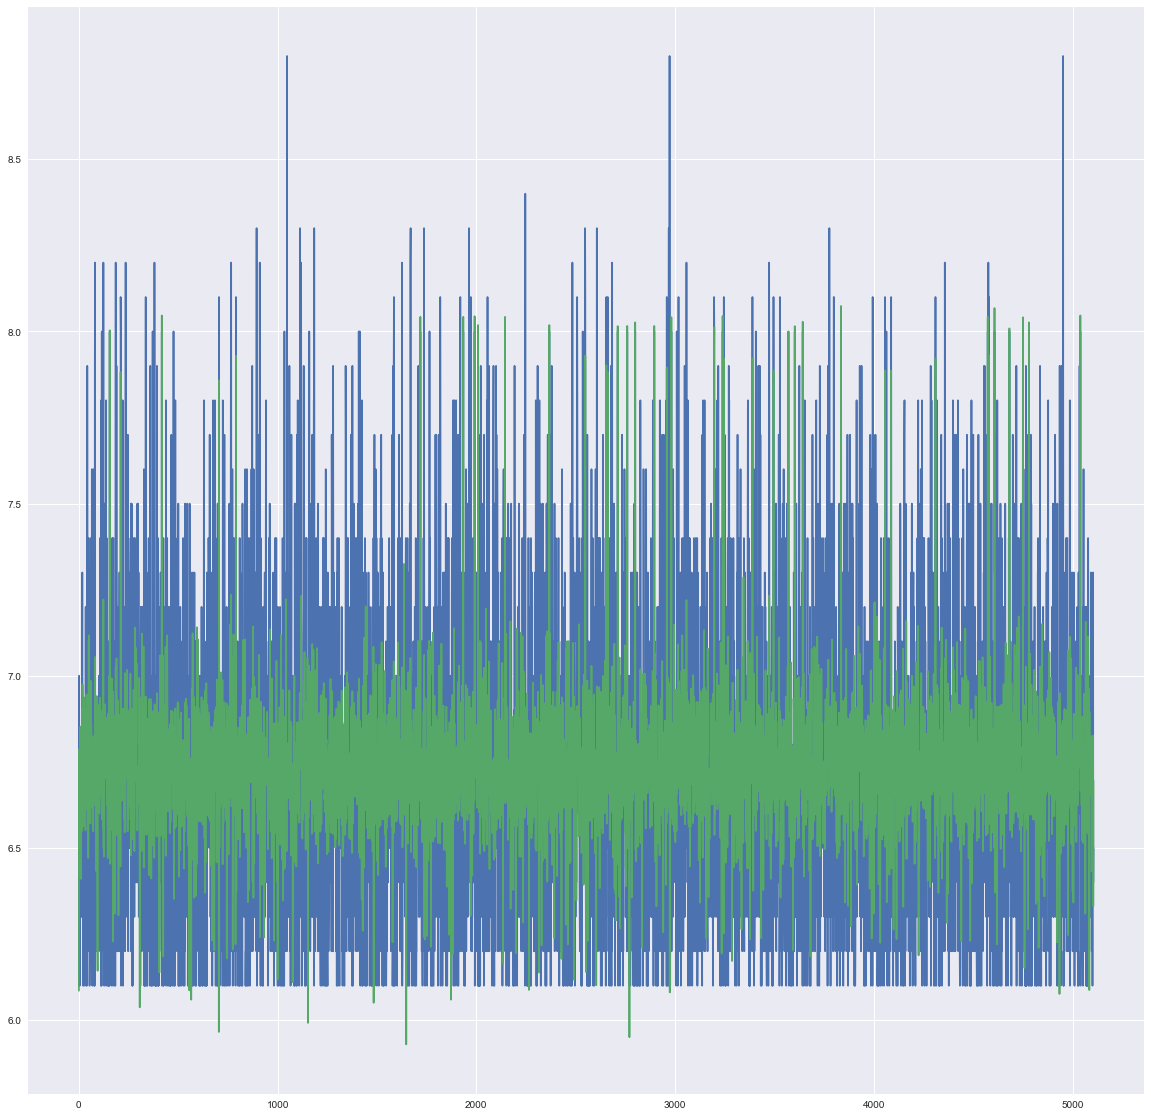

In [238]:
pred = reg_a.predict(X_test)

plt.plot(y_test.values)
plt.plot(pred)

In [240]:
print('Medianas')
print(y_above.median(),y_below.median(),y_final_above.median(),y_final_below.median() )
print('Variância')
print(y_above.var(),y_below.var(),y_final_above.var(),y_final_below.var() )

Medianas
6.6 5.5 5.2 4.1
Variância
0.2330927736053826 0.42820241928372815 0.222098169103051 0.25933305522476907


In [242]:
[(y, x) for x, y in sorted(zip(reg_a.coef_, X_test.columns))]

[('in_educacao_indigena', -0.50514931706848742),
 ('in_lixo_enterra', -0.42342557581323698),
 ('in_local_func_templo_igreja', -0.42131023370895149),
 ('form_adequada_ensino_religioso', -0.13898097059263301),
 ('in_cozinha', -0.12441798838701261),
 ('in_agua_inexistente', -0.12307442328252083),
 ('num_alunos_por_sala_existente', -0.11193228619075271),
 ('form_adequada_estudos_sociais', -0.1092401736813698),
 ('in_equip_dvd', -0.085175062291035983),
 ('in_predio_compartilhado', -0.079260469391263869),
 ('in_local_func_salas_outra_esc', -0.058004925533121199),
 ('in_banheiro_fora_predio', -0.051723707085563134),
 ('ensina_disc_educacao_fisica', -0.051381226300545639),
 ('turmas_por_professor', -0.04954866681110362),
 ('in_energia_gerador', -0.046154925270821726),
 ('in_quadra_esportes', -0.044029017985377256),
 ('tem_formacao_historia', -0.042764497605293168),
 ('in_dependencias_pne', -0.041834852298579771),
 ('tem_formacao_lingua_estrangeira', -0.040356547944159223),
 ('form_adequada_qui

In [247]:
esc_ideb_clean_below = clean_and_drop(esc_ideb_clean_below)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    esc_ideb_clean_below, y_below, test_size=0.2)

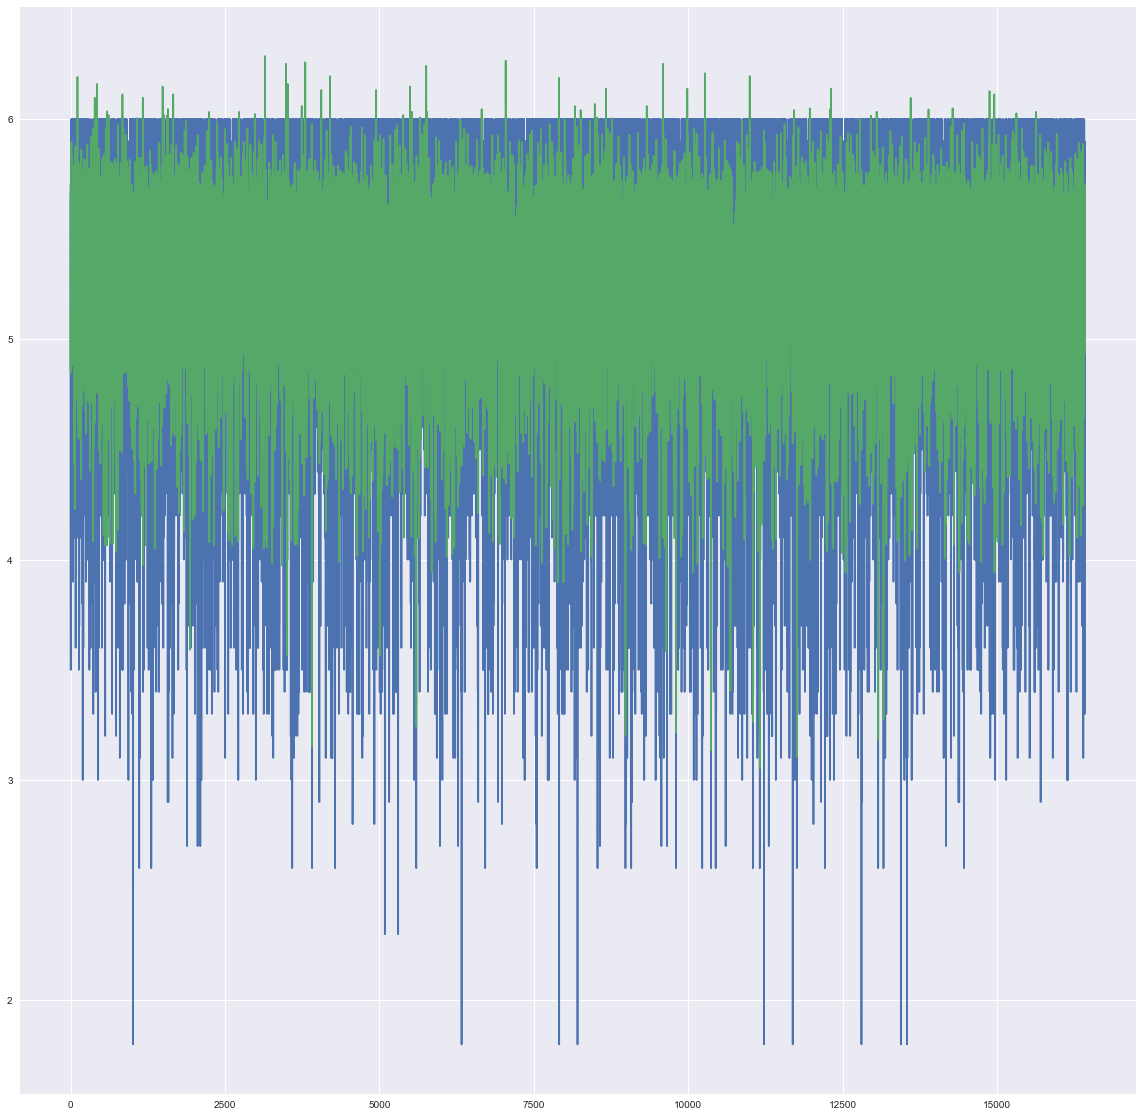

In [248]:
reg_b, score = regressao_escolas_ideb(X_train, y_train.values)

In [249]:
score

0.27539764208961237

In [250]:
pred = reg_b.predict(X_test)

plt.plot(y_test.values)
plt.plot(pred)

In [130]:
[(y, x) for x, y in sorted(zip(reg_d.coef_, esc_ideb_clean_below.columns))]

[('in_somente_matriculas_ac_ou_aee', -0.31828408757709298),
 ('in_energia_inexistente', -0.29896282283459141),
 ('in_agua_cacimba', -0.28953039150723614),
 ('in_local_func_unid_prisional', -0.25036736731882847),
 ('in_equip_impressora', -0.24663874132917432),
 ('form_adequada_quimica', -0.24293706483511662),
 ('in_lixo_recicla', -0.2223933145551627),
 ('in_lixo_joga_outra_area', -0.18076456291225798),
 ('in_banheiro_dentro_predio', -0.13779936995926434),
 ('in_agua_rede_publica', -0.1265365176806108),
 ('tem_formacao_estudos_sociais', -0.10160482135454196),
 ('tem_formacao_filosofia', -0.094648630943696022),
 ('tem_formacao_biologia', -0.08593982747819022),
 ('in_esgoto_fossa', -0.085184592932401035),
 ('in_computador', -0.067491123181097845),
 ('in_quadra_esportes', -0.066123779218722673),
 ('ensina_disc_ensino_religioso', -0.063577360874491132),
 ('in_local_func_templo_igreja', -0.060671357344699015),
 ('tem_formacao_fisica', -0.060475074006909657),
 ('in_banheiro_pne', -0.0563619869

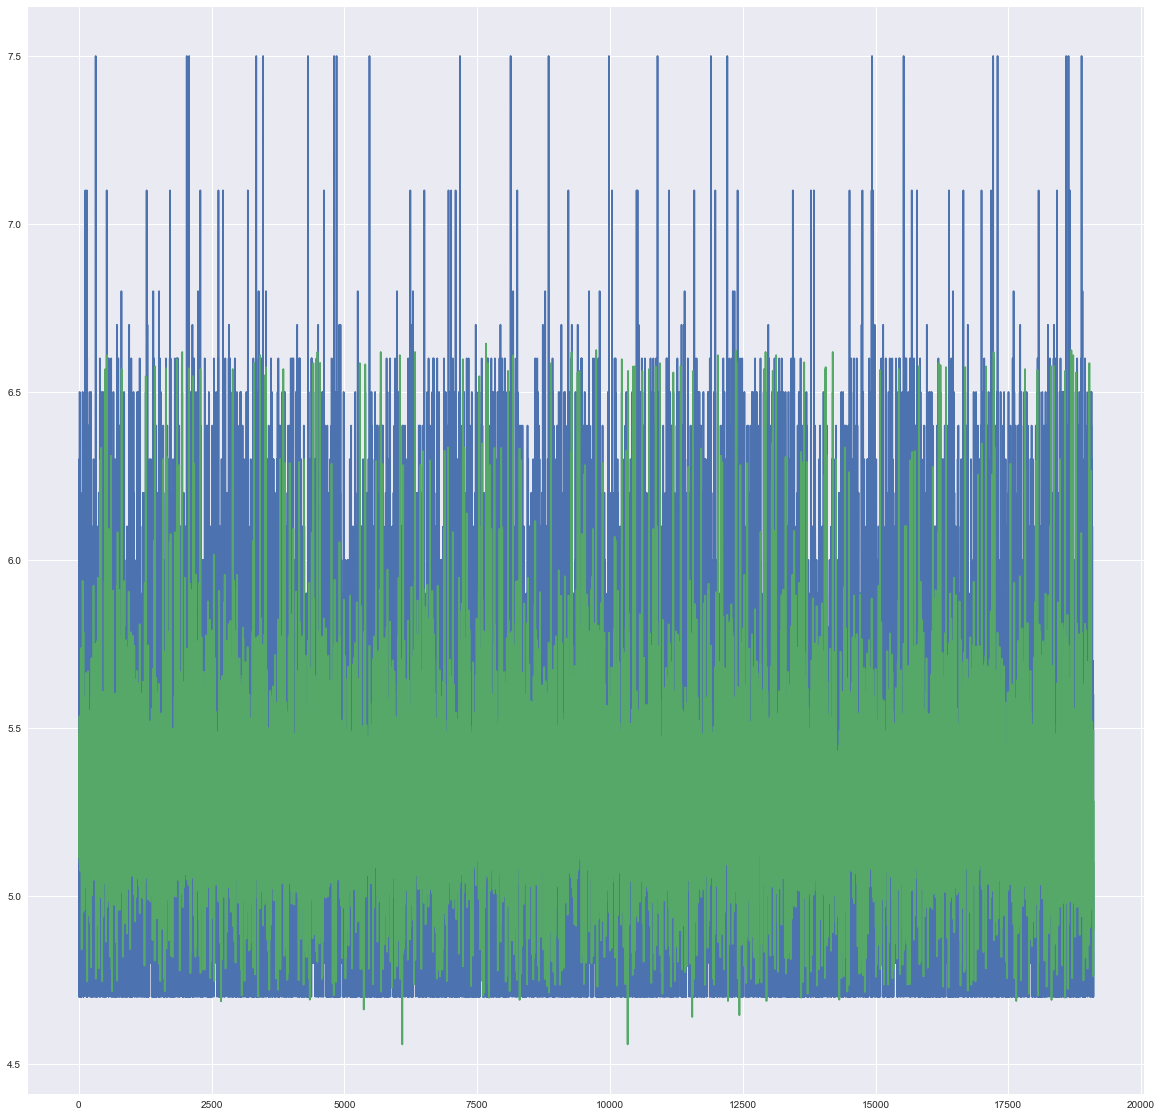

In [253]:
esc_ideb_clean_final_above = clean_and_drop(esc_ideb_clean_final_above)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    esc_ideb_clean_final_above, y_final_above, test_size=0.2)

reg_c, score = regressao_escolas_ideb(X_train, y_train.values)


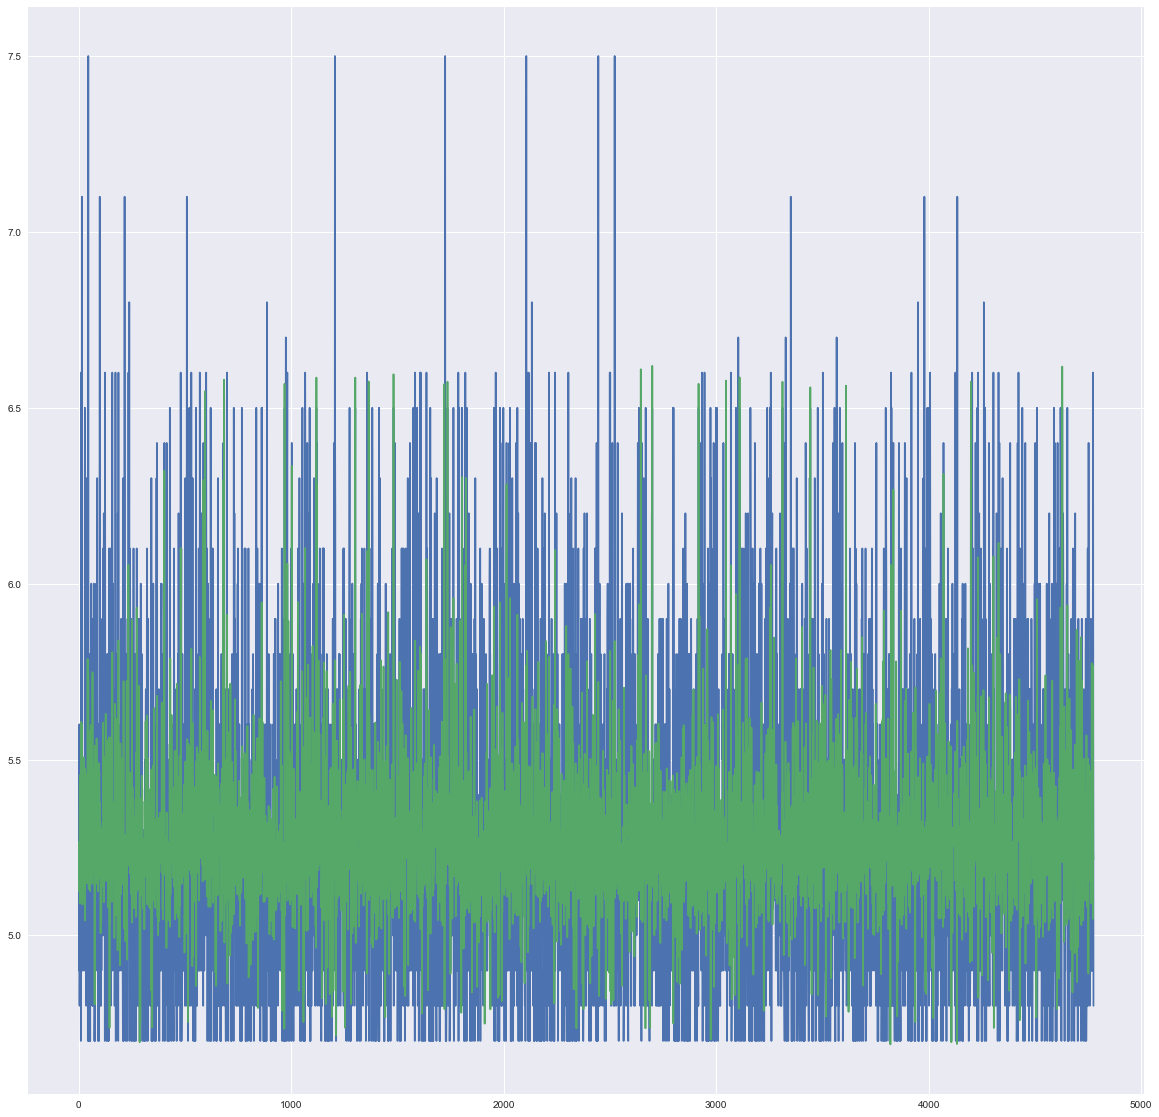

In [255]:

score

pred = reg_c.predict(X_test)

plt.plot(y_test.values)
plt.plot(pred)



In [256]:
[(y, x) for x, y in sorted(zip(reg_c.coef_, esc_ideb_clean_below.columns))]

[('in_alimentacao', -0.57660547607913837),
 ('in_local_func_templo_igreja', -0.57293607471460761),
 ('in_agua_fonte_rio', -0.47238145114203944),
 ('in_local_func_unid_prisional', -0.41822183669016527),
 ('in_energia_gerador', -0.40633740063912077),
 ('form_adequada_biologia', -0.35094283749028488),
 ('in_lixo_recicla', -0.18098956492934673),
 ('funcionarios_por_professor', -0.14939173834080616),
 ('tem_formacao_historia', -0.14885272774112623),
 ('in_sala_atendimento_especial', -0.11419347789883737),
 ('in_local_func_outros', -0.11096825327037657),
 ('in_local_func_salas_empresa', -0.08268392632312288),
 ('in_lixo_outros', -0.079082943397585245),
 ('in_cozinha', -0.073205186008444806),
 ('form_adequada_sociologia', -0.072072776853421255),
 ('in_energia_rede_publica', -0.067784165300065272),
 ('in_equip_tv', -0.058716325748125867),
 ('tem_formacao_lingua_portuguesa', -0.048878486958631534),
 ('form_adequada_filosofia', -0.039209833544629133),
 ('ensina_disc_fisica', -0.03475028018052054

In [257]:
rnd_clf = RandomForestRegressor(n_estimators = 100 ,random_state = 0)
rnd_clf.fit(X_train, y_train);

In [258]:
[(y, x) for x, y in sorted(zip(rnd_clf.feature_importances_, esc_ideb_clean_above.columns))]

[('alunos_por_prof_fund_af', 0.0),
 ('ensina_disc_biologia', 0.0),
 ('ensina_disc_educacao_fisica', 0.0),
 ('ensina_disc_ensino_religioso', 0.0),
 ('ensina_disc_estudos_sociais', 0.0),
 ('ensina_disc_filosofia', 0.0),
 ('ensina_disc_geografia', 0.0),
 ('ensina_disc_quimica', 0.0),
 ('form_adequada_educacao_fisica', 0.0),
 ('form_adequada_ensino_religioso', 0.0),
 ('form_adequada_estudos_sociais', 0.0),
 ('form_adequada_filosofia', 0.0),
 ('form_adequada_geografia', 0.0),
 ('form_adequada_historia', 0.0),
 ('form_adequada_lingua_estrangeira', 0.0),
 ('form_adequada_quimica', 0.0),
 ('num_disciplinas_ensina', 0.0),
 ('tem_formacao_biologia', 0.0),
 ('tem_formacao_educacao_fisica', 0.0),
 ('tem_formacao_ensino_religioso', 0.0),
 ('tem_formacao_estudos_sociais', 0.0),
 ('tem_formacao_filosofia', 0.0),
 ('tem_formacao_fisica', 0.0),
 ('tem_formacao_geografia', 0.0),
 ('tem_formacao_historia', 2.0775851597228024e-08),
 ('ensina_disc_historia', 4.3897516986018737e-08),
 ('form_adequada_sociol

In [133]:
esc_ideb_clean['alunos_por_turma'][esc_ideb_clean['Ideb2017'] ].mean()

nan

In [134]:
rnd_clf = RandomForestRegressor(n_estimators = 100 ,random_state = 0)
rnd_clf.fit(esc_ideb_clean_below, y_below);

[(y, x) for x, y in sorted(zip(rnd_clf.feature_importances_, esc_ideb_clean_below.columns))]

[('ensina_disc_biologia', 0.0),
 ('ensina_disc_educacao_fisica', 0.0),
 ('ensina_disc_estudos_sociais', 0.0),
 ('ensina_disc_filosofia', 0.0),
 ('ensina_disc_fisica', 0.0),
 ('ensina_disc_geografia', 0.0),
 ('ensina_disc_quimica', 0.0),
 ('ensina_disc_sociologia', 0.0),
 ('form_adequada_artes', 0.0),
 ('form_adequada_educacao_fisica', 0.0),
 ('form_adequada_ensino_religioso', 0.0),
 ('form_adequada_estudos_sociais', 0.0),
 ('form_adequada_filosofia', 0.0),
 ('form_adequada_fisica', 0.0),
 ('form_adequada_historia', 0.0),
 ('form_adequada_lingua_estrangeira', 0.0),
 ('form_adequada_quimica', 0.0),
 ('form_adequada_sociologia', 0.0),
 ('in_energia_inexistente', 0.0),
 ('in_somente_matriculas_ac_ou_aee', 0.0),
 ('tem_formacao_biologia', 0.0),
 ('tem_formacao_educacao_fisica', 0.0),
 ('tem_formacao_ensino_religioso', 0.0),
 ('tem_formacao_filosofia', 0.0),
 ('tem_formacao_historia', 0.0),
 ('tem_formacao_sociologia', 0.0),
 ('form_adequada_biologia', 5.6550084510971825e-09),
 ('form_adequa